## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib notebook

## First: camera calibration using chessboard images
This is a one-time cost so better do it separately from the rest of the pipeline

In [2]:
### parameters
nx=9
ny=6
#Calibrate camera
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img,(nx,ny), corners, ret)
cv2.destroyAllWindows()
 
#extract camera matrix 1 distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)

## Second: Image pipeline

### Helper functions

In [154]:
#1. Correct distortion : no function
#2. Create binary threshold image
def create_binary(img, lthd=(170, 255), bthd=(20, 100),sthd=(80,100)):
    def bin_it(image, threshold):
        output_bin = np.zeros_like(image)
        output_bin[(image >= threshold[0]) & (image <= threshold[1])]=1
        return output_bin

    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2] # for yellow lanes
    l_channel = lab[:,:,0] # for white lanes
    s_channel = hls[:,:,2]
    
    l_channel = l_channel*(255/np.max(l_channel))
    l_output = np.zeros_like(l_channel)
    l_output[(l_channel > lthd[0]) & (l_channel <= lthd[1])] = 1
    
    s_channel = s_channel*(255/np.max(s_channel))
    s_output = np.zeros_like(l_channel)
    s_output[(s_channel > sthd[0]) & (s_channel <= sthd[1])] = 1
    
    if np.max(b_channel) > 175:
        b_channel = b_channel*(255/np.max(b_channel))
    b_output = np.zeros_like(b_channel)
    b_output[((b_channel > bthd[0]) & (b_channel <= bthd[1]))] = 1
    
    # binary threshold values
    bin_thresh = [20, 255]      
    # rgb yellow
    lower = np.array([225,180,0],dtype = "uint8")
    upper = np.array([255, 255, 170],dtype = "uint8")
    mask = cv2.inRange(img, lower, upper)
    rgb_y = cv2.bitwise_and(img, img, mask = mask).astype(np.uint8)
    rgb_y = cv2.cvtColor(rgb_y, cv2.COLOR_RGB2GRAY)
    rgb_y = bin_it(rgb_y, bin_thresh)

    # rgb white
    lower = np.array([100,100,200],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    mask = cv2.inRange(img, lower, upper)
    rgb_w = cv2.bitwise_and(img, img, mask = mask).astype(np.uint8)
    rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY)
    rgb_w = bin_it(rgb_w, bin_thresh)

    # hls yellow
    lower = np.array([20,120,80],dtype = "uint8")
    upper = np.array([45, 200, 255],dtype = "uint8")
    mask = cv2.inRange(hls, lower, upper)
    hls_y = cv2.bitwise_and(img, img, mask = mask).astype(np.uint8)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2RGB)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
    hls_y = bin_it(hls_y, bin_thresh)
    
    color_binary=np.zeros_like(b_channel)
    color_binary[(b_output==1) | (l_output==1) | (hls_y==1) | (rgb_w==1) | (rgb_y==1)]=1
#     color_binary=np.zeros_like(b_channel)
#     color_binary[(b_output==1) | (l_output==1)]=1
    return color_binary

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#3. Warp image
def transform_perspective(img,src,offset=20):
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                    [img_size[0]-offset, img_size[1]-offset], 
                    [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped_img = cv2.warpPerspective(img, M, img_size)
    return warped_img, M, Minv

#4. Detect lane lines in the image
def find_lane_lines(img,nwindows,margin,minpix):
    
    histogram=np.sum(img[int(img.shape[0]/2):img.shape[0],:],0)
    mid_point=int(histogram.shape[0]/2)
    left_point=mid_point-30
    right_point=mid_point+30
    leftx_base=np.argmax(histogram[:mid_point])
    rightx_base=np.argmax(histogram[mid_point:])+mid_point
    #print(mid_point,leftx_base,rightx_base)
    #x,y positions for non zero pixels
    window_height=img.shape[0]//nwindows
    non_zero=img.nonzero()
    non_zerox=np.array(non_zero[1])
    non_zeroy=np.array(non_zero[0])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # track curvature by iterating through nwindows
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((non_zeroy >= win_y_low) & (non_zeroy <= win_y_high) &
                          (non_zerox >=  win_xleft_low) & (non_zerox <= win_xleft_high))
        good_left_inds=np.where(good_left_inds !=0)[0]
        good_right_inds = ((non_zeroy >= win_y_low) & (non_zeroy <= win_y_high) &
                           (non_zerox >=  win_xright_low) & (non_zerox <= win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds)>minpix:
            leftx_current=np.int(np.mean(non_zerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current=np.int(np.mean(non_zerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = non_zerox[left_lane_inds]
    lefty = non_zeroy[left_lane_inds] 
    rightx = non_zerox[right_lane_inds]
    righty = non_zeroy[right_lane_inds]
    left_found=len(lefty)>0
    right_found=len(righty)>0
    return leftx,lefty,rightx,righty,left_found,right_found

#5. Fit lane lines to the picture
def fit_lane_lines(img,leftx,lefty,rightx,righty,left_found,right_found):
    left_fitx=np.array([])
    right_fitx=np.array([])
    left_fit=np.array([])
    right_fit=np.array([])
    out_img = np.dstack((img,img,img))
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    # scenario1: no lanes are found
    if ((not left_found) | (not right_found)): 
        left_fitx=tracker.leftFit
        right_fitx=tracker.rightFit
        tracker.detected=False
    #scenario2: only right is found
    if right_found is True and left_found is False: 
        right_fit = np.polyfit(righty,rightx,2)
        try:
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            right_fitx = 1*ploty**2 + 1*ploty
        tracker.rightFit=right_fitx
        
        tracker.detected=True
    #scenario3: only left is found
    if left_found is True and right_found is False:
        left_fit = np.polyfit(lefty,leftx,2)
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        except TypeError:
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
        #see if the fitted values make sense
        tracker.leftFit=left_fitx
        tracker.detected=True
    #scenario4: both lanes are found
    if left_found is True and right_found is True:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
        print(left_fit,right_fit)
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
        #check for straight line:
        if ((np.abs(left_fit[0])<1e-3) & (np.abs(right_fit[0])<1e-3)): 
            #update road width information
            if (tracker.roadWidth==0):
                tracker.roadWidth=np.abs(right_fit[2]-left_fit[0])
            else:
                tracker.roadWidth=0.5*np.abs(right_fit[2]-left_fit[0])+0.5*tracker.roadWidth
        #check if fit is good:
        #if ()
        tracker.leftFit=left_fitx
        tracker.rightFit=right_fitx
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    return out_img
#6. Compute curvature & vehicle position
#7. Unwarp: no function 
#8. Output result
def weighted_img(img, initial_img, α=0.8, β=0.7, γ=0):
    return cv2.addWeighted(initial_img, α, np.uint8(img), β, γ)

### Tracker class

In [155]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False
        self.leftFit = [] # x values of the previous left lane
        self.rightFit = [] # x values of the previous right lane
        self.roadCurve= 100
        self.roadWidth=10


### Pipeline function

In [156]:
def image_pipeline(img):
    
    imsize=(img.shape[1],img.shape[0])
    #### Parameters list
    #Camera params (loaded in 1st part): nx,ny,mtx,dist,rvecs,tvecs
    #distortion: no parameters
    #binary threshold image:
    sthd=(70,150)
    lthd=(200,255)
    bthd=(200,255)
    #gaussian filter
    kernelSize=1
    #warp/unwarp image:
    offset=200
    #src=np.float32([[542,485],[743,485],[1000,648],[317,648]]) # tight boundary around the road
    src=np.float32([[506,515],[790,515],[1037,672],[290,672]]) # pipeline boundary
    #detect/fit lane lines
    nwindows = 3
    margin = 150 
    minpix = 40
    margin2=100 #margin value for search around existing poly
    
    #undistort image
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    #convert image to binary
    #bin_im=create_binary(undst,lthd,bthd,sthd)
    bin_im=create_binary(undst,lthd,bthd,sthd)
    #Apply gaussian filter
    blurred=gaussian_blur(bin_im,kernelSize)
    #transform perspective
    warped,M,Minv=transform_perspective(bin_im,src,offset)
    #find lane lines
    leftx,lefty,rightx,righty,left_found,right_found=find_lane_lines(warped,nwindows,margin,minpix)
    #fit lane lines
    out_img=fit_lane_lines(warped,leftx,lefty,rightx,righty,left_found,right_found)
    #unwarp
    unwarped=cv2.warpPerspective(out_img, Minv, imsize)
    #restor background
    res=weighted_img(unwarped,img)
    return res

### Convert png images (from video) to jpg

In [157]:
# imname='test_images/challenge_video17.png'
# image = cv2.imread(imname)
# cv2.imwrite(imname[:-3] + 'jpg', image)

### Finding source points

### Parameters tuning

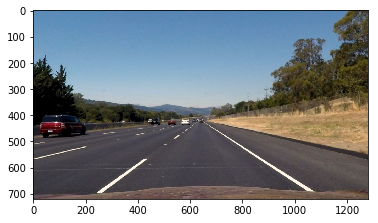

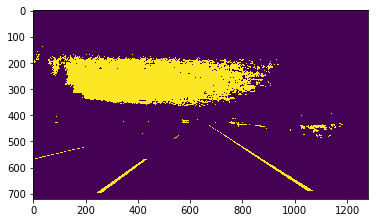

[  6.25257529e-05  -3.00148230e-02   1.93539206e+02] [  3.18394126e-05  -3.31807054e-02   1.08347523e+03]


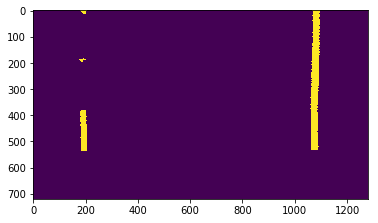

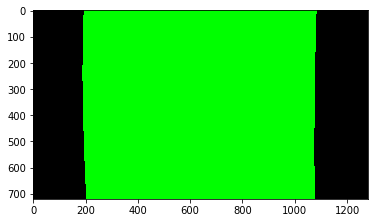

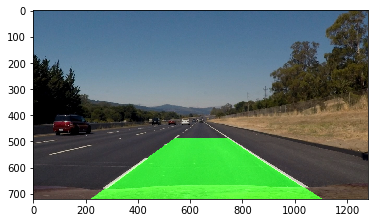

In [161]:
%matplotlib inline
tracker=Line()
imname='test_images/straight_lines2.jpg'
image = mpimg.imread(imname)
undst_im = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(undst_im)
plt.show()
tracker=Line()
# lab = cv2.cvtColor(yellow, cv2.COLOR_RGB2Lab)

sthd=(70,150)
lthd=(200,255)
bthd=(200,255)

# cx_image0 = create_binary(undst_im,lthd,bthd,(254,255)) #without S_channel
# plt.imshow(cx_image0)
plt.show()
cx_image = create_binary(undst_im,lthd,bthd,sthd)
plt.imshow(cx_image)
plt.show()

#blurred=gaussian_blur(cx_image,1)
#plt.show()
#plt.imshow(blurred)

srcpt=np.float32([[506,515],[790,515],[1037,672],[290,672]]) # boundary from straight line 2
ww,mm,mminv=transform_perspective(cx_image,srcpt,200)
plt.show()
plt.imshow(ww)
leftx,lefty,rightx,righty,left_found,right_found=find_lane_lines(ww,3,150,40)
out_i=fit_lane_lines(ww,leftx,lefty,rightx,righty,left_found,right_found)
plt.show()
plt.imshow(out_i)
unw=cv2.warpPerspective(out_i, mminv, (image.shape[1],image.shape[0]))
plt.show()
#plt.imshow(unw)

rer=weighted_img(np.uint8(unw),image)
plt.show()
plt.imshow(rer)

### Pipeline

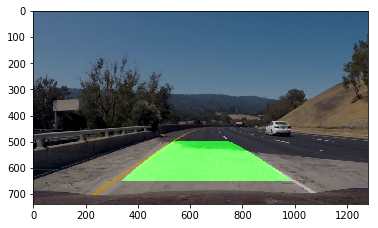

In [716]:
im=image_pipeline(image)
%matplotlib inline
plt.imshow(im)
plt.savefig(imname.replace('test_images','output_images'))

## Third: Video pipeline

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

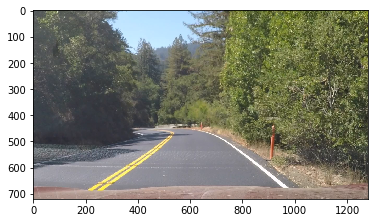

In [134]:
clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4")
im0=clip1.get_frame(0)
plt.imshow(im0)

In [137]:
tracker=Line()
white_output = 'output_videos/challenge_video2.mp4'
clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4").subclip(0,10)
#clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video2.mp4
[MoviePy] Writing video output_videos/challenge_video2.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 1/251 [00:00<00:39,  6.27it/s]

  1%|          | 2/251 [00:00<00:40,  6.12it/s]

  1%|          | 3/251 [00:00<00:40,  6.09it/s]

  2%|▏         | 4/251 [00:00<00:40,  6.17it/s]

  2%|▏         | 5/251 [00:00<00:38,  6.34it/s]

  2%|▏         | 6/251 [00:00<00:38,  6.38it/s]

  3%|▎         | 7/251 [00:01<00:39,  6.16it/s]

  3%|▎         | 8/251 [00:01<00:39,  6.18it/s]

  4%|▎         | 9/251 [00:01<00:39,  6.18it/s]

  4%|▍         | 10/251 [00:01<00:38,  6.18it/s]

  4%|▍         | 11/251 [00:01<00:38,  6.22it/s]

  5%|▍         | 12/251 [00:01<00:38,  6.26it/s]

  5%|▌         | 13/251 [00:02<00:38,  6.26it/s]

  6%|▌         | 14/251 [00:02<00:37,  6.26it/s]

  6%|▌         | 15/251 [00:02<00:37,  6.24it/s]

  6%|▋         | 16/251 [00:02<00:37,  6.25it/s]

  7%|▋         | 17/251 [00:02<00:37,  6.25it/s]

  7%|▋         | 18/251 [00:02<00:37,  6.26it/s]

  8%|▊         | 19/251 [00:03<00:37,  6.26it/s]

  8%|▊         |

 58%|█████▊    | 145/251 [00:25<00:18,  5.64it/s]

 58%|█████▊    | 146/251 [00:25<00:18,  5.64it/s]

 59%|█████▊    | 147/251 [00:26<00:18,  5.64it/s]

 59%|█████▉    | 148/251 [00:26<00:18,  5.64it/s]

 59%|█████▉    | 149/251 [00:26<00:18,  5.64it/s]

 60%|█████▉    | 150/251 [00:26<00:17,  5.64it/s]

 60%|██████    | 151/251 [00:26<00:17,  5.64it/s]

 61%|██████    | 152/251 [00:26<00:17,  5.64it/s]

 61%|██████    | 153/251 [00:27<00:17,  5.65it/s]

 61%|██████▏   | 154/251 [00:27<00:17,  5.65it/s]

 62%|██████▏   | 155/251 [00:27<00:16,  5.65it/s]

 62%|██████▏   | 156/251 [00:27<00:16,  5.65it/s]

 63%|██████▎   | 157/251 [00:27<00:16,  5.66it/s]

 63%|██████▎   | 158/251 [00:27<00:16,  5.66it/s]

 63%|██████▎   | 159/251 [00:28<00:16,  5.67it/s]

 64%|██████▎   | 160/251 [00:28<00:16,  5.67it/s]

 64%|██████▍   | 161/251 [00:28<00:15,  5.67it/s]

 65%|██████▍   | 162/251 [00:28<00:15,  5.67it/s]

 65%|██████▍   | 163/251 [00:28<00:15,  5.67it/s]

 65%|██████▌   | 164/251 [00:28

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video2.mp4 

CPU times: user 1min 31s, sys: 10.3 s, total: 1min 41s
Wall time: 46.8 s


In [138]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))